In [1]:
import croissant as cro
import healpy
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [2]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)

In [3]:
beam = cro.beam.Beam(power, theta, phi, frequencies=freq)

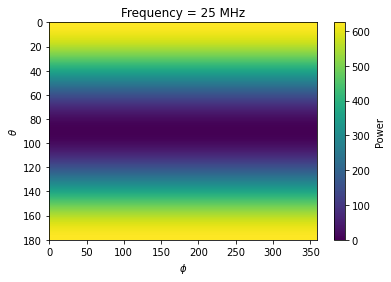

In [4]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

Vizualize the beam with a healpix map

In [12]:
T, P = np.meshgrid(beam.theta, beam.phi)
alm = cro.healpix.angle2alm(beam.data[25], T, P, lmax=2)

In [60]:
from pyshtools.expand import SHExpandLSQ, SHExpandDH, MakeGrid2D

In [98]:
LMAX = 20
th = np.rad2deg(np.pi/2 - T.ravel())
ph = np.rad2deg(P.ravel())
cilm, chisq = SHExpandLSQ(beam.data[25].ravel(), th, ph, LMAX, norm=4, csphase=-1)
print(chisq)

print(th)
print(ph)
print(beam.data[25].ravel())

97308991.16294464
[ 90.  89.  88. ... -88. -89. -90.]
[  0.   0.   0. ... 359. 359. 359.]
[676. 676. 676. ... 676. 676. 676.]


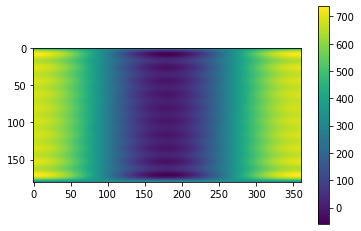

In [99]:
grid = MakeGrid2D(cilm, 1, lmax=LMAX, norm=4, csphase=-1)
plt.figure()
plt.imshow(grid)
plt.colorbar()
plt.show()

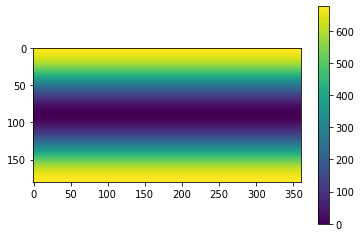

In [97]:
gridh = beam.data[25, :-1]
cilm = SHExpandDH(gridh, norm=4, sampling=2, csphase=-1, lmax_calc=LMAX)
grid = MakeGrid2D(cilm, 1, lmax=LMAX, norm=4, csphase=-1)
plt.figure()
plt.imshow(grid)
plt.colorbar()
plt.show()

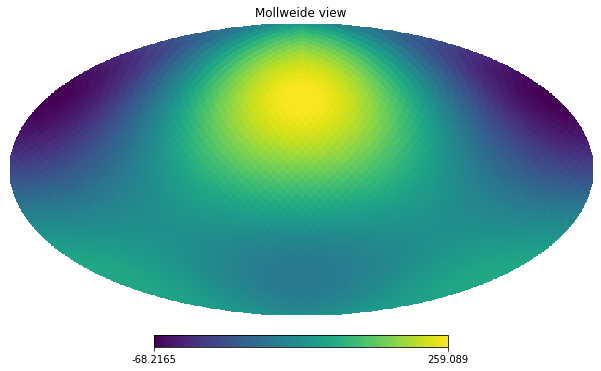

In [14]:
healpy.mollview(healpy.alm2map(alm[0], nside=16))

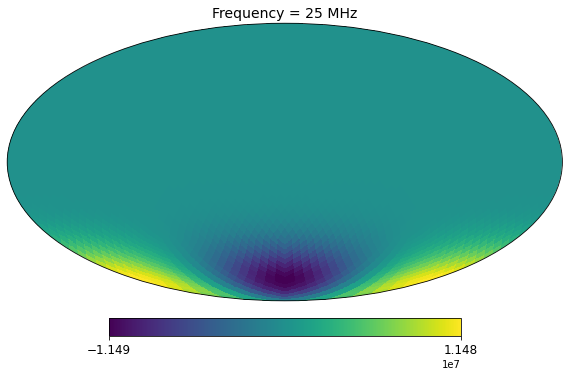

In [11]:
plot_freq = 25  # MHz
beam_alm = cro.healpix.Alm.from_angles(
    beam.data, beam.theta, beam.phi, frequencies=beam.frequencies, lmax=10, coords="topographic",
)
freq_ix = np.argmin(np.abs(beam_alm.frequencies-plot_freq))
hp_map = beam_alm.hp_map(nside=16)
healpy.projview(
    hp_map[freq_ix], title=f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz", projection_type="mollweide"
)


We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [7]:
sky = cro.sky.Sky.gsm(25, res="lo")
sky.power_law_map(beam.frequencies, spectral_index=-2.5)

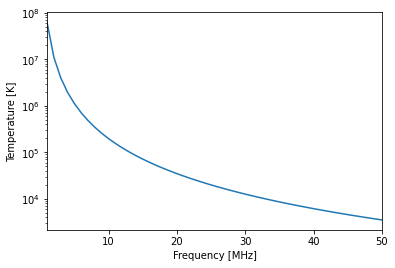

In [8]:
# the sky model is indeed a perfect power law
plt.figure()
plt.plot(sky.frequencies, sky.data[:,0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.frequencies.min(), sky.frequencies.max())
plt.yscale("log")
plt.show()

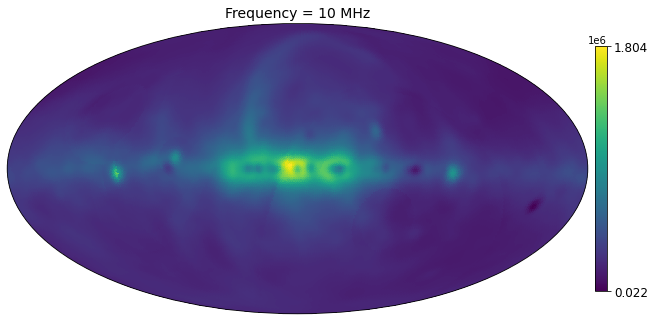

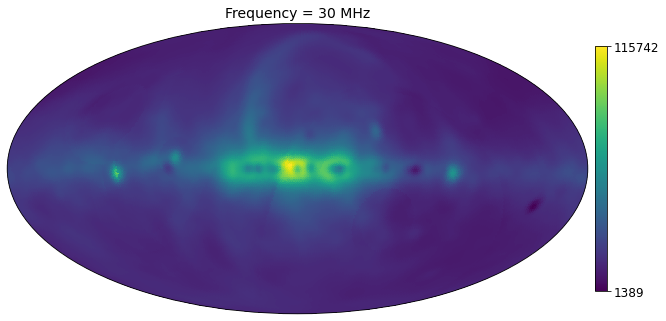

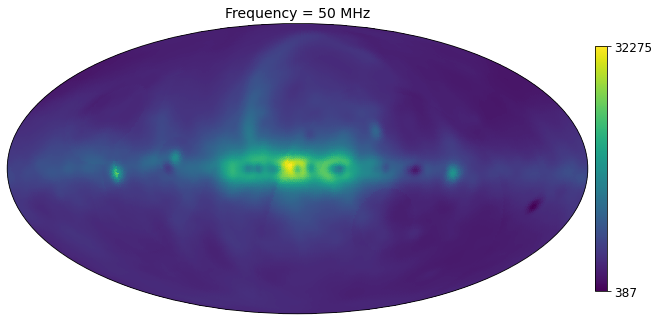

In [9]:
for freq in sky.frequencies[9::20]:
    sky.plot(frequency=freq, cbar=True, cb_orientation="vertical", projection_type="mollweide")

Run the simulator!

In [ ]:
# let's do a full day

sim = cro.simulator.Simulator(
    beam, sky, 10, (37.8, 122.3, 0), t_start="2022-06-02T15:43:43", N_times=10, t_end="2022-06-03T15:43:43"
)
sim.run(parallel=False)

prep beam
len(data)=50
dec=array([0.91027137, 0.91027137, 0.91027137, ..., 2.23130895, 2.23130895,
       2.23130895])
ra=array([4.34792662, 4.34792662, 4.34792662, ..., 1.20658274, 1.20658274,
       1.20658274])
i=0


In [14]:
a = np.arange(10)
a.shape = (5, 2)


In [19]:
a.reshape?

In [17]:
a.ravel(axis=0)

TypeError: ravel() got an unexpected keyword argument 'axis'

In [12]:
%debug

> /home/christian/Documents/projects/croissant/.venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py(1584)__init__()
   1582         if np.issubclass_(w, float):
   1583             w = ones(len(theta)) * w
-> 1584         nt_, tt_, np_, tp_, c, fp, ier = dfitpack.spherfit_smth(theta, phi,
   1585                                                                 r, w=w, s=s,
   1586                                                                 eps=eps)

ipdb> u
> /home/christian/Documents/projects/croissant/.venv/lib/python3.8/site-packages/croissant/simulator.py(84)_prepare_beam()
     82         smooth_ra = np.linspace(-np.pi, np.pi, 360, endpoint=False)
     83         smooth_dec_grid, smooth_ra_grid = np.meshgrid(smooth_dec, smooth_ra)
---> 84         interp = SmoothSphereBivariateSpline(dec, ra, data)
     85         interp_beam = interp(smooth_dec_grid, smooth_ra_grid)
     86         # compute alms of beam from ra/dec

ipdb> data.shape
(3258000,)
ipdb> data.shape[0] /

In [11]:
from astropy.coordinates import AltAz

In [12]:
phi, theta = sim.beam.phi, sim.beam.theta

In [15]:
phi.shape = (1, -1)
theta.shape = (-1, 1)

In [16]:
from astropy import units
azs = phi * units.rad
alts = (np.pi / 2 - theta) * units.rad

In [20]:
from astropy.time import Time

In [32]:
from astropy.coordinates import EarthLocation, ICRS
loc = EarthLocation(lon=40*units.deg, lat=40*units.deg, height=0*units.m)

In [27]:
aa = AltAz(az=azs, alt=alts, location=loc, obstime=Time("2022-06-02T15:43:43"))

In [34]:
ICRS?

In [46]:
r = aa.transform_to(ICRS()).ra.rad

In [51]:
r[:, 0]

array([2.90965068, 2.90963505, 2.90961894, 2.90960231, 2.90958512,
       2.90956734, 2.90954891, 2.90952981, 2.90950996, 2.90948933,
       2.90946784, 2.90944544, 2.90942203, 2.90939755, 2.9093719 ,
       2.90934498, 2.90931667, 2.90928684, 2.90925535, 2.90922204,
       2.90918673, 2.9091492 , 2.9091092 , 2.90906648, 2.9090207 ,
       2.9089715 , 2.90891845, 2.90886104, 2.90879866, 2.90873062,
       2.90865604, 2.9085739 , 2.90848291, 2.90838151, 2.90826772,
       2.90813906, 2.9079923 , 2.90782323, 2.90762622, 2.90739357,
       2.90711445, 2.90677318, 2.90634612, 2.90579588, 2.90505969,
       2.90402336, 2.90245519, 2.89980238, 2.89433986, 2.87655987,
       0.02326869, 6.07834909, 6.06573413, 6.06121778, 6.05889537,
       6.05748   , 6.05652664, 6.05584046, 6.05532267, 6.05491786,
       6.0545925 , 6.05432516, 6.05410146, 6.05391142, 6.05374788,
       6.05360558, 6.05348056, 6.05336981, 6.05327094, 6.05318209,
       6.05310178, 6.05302877, 6.05296209, 6.05290091, 6.05284

In [44]:
np.allclose(aa.transform_to(ICRS()).ra.rad[0], aa.transform_to(ICRS()).ra.rad[1])

False

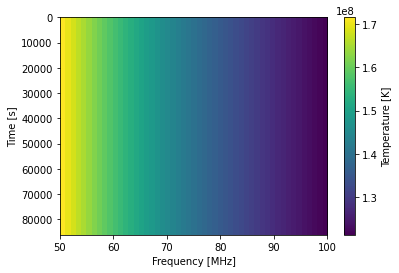

In [35]:
sim.plot()

Comment: This waterfall does not change with time. The reason is the azimuthal symmetry of the short dipole (only m=0 modes). We can add non-zero m-mode and see the change with time.

In [36]:
for i, freq in enumerate(beam.frequencies):
    a11 = (ant_length * freq)**2
    beam.set_coeff(a11, 1, 1, freq_idx=i)

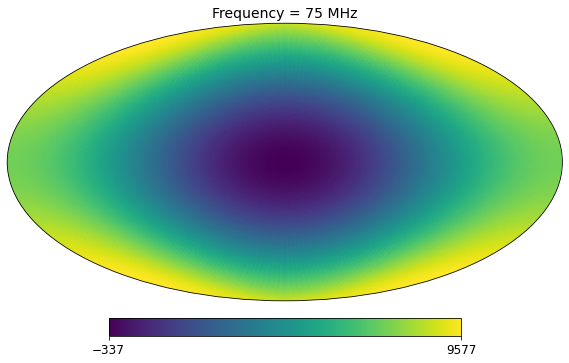

In [37]:
beam_hp = cro.healpix.HealpixMap.from_alm(beam, nside=32)
beam_hp.plot(frequency=75, cbar=True, cb_orientation="horizontal", projection_type="mollweide")

In [38]:
# since we anticpate this plot to look more interesting, we will increase the time resolution
# therefore, we use the parallel computation mode to make it run fast
times = np.linspace(0, 86164.0905, 100000)
sim = cro.simulator.Simulator(beam, sky, times)
sim.run(parallel=True, ncpu=10)

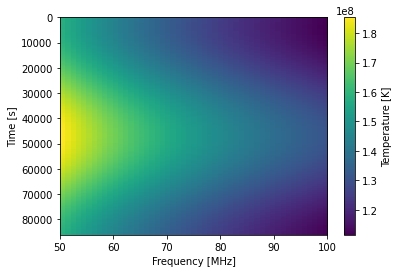

In [39]:
sim.plot()